In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
DATASET_PATH = 'train.csv'
PREPARED_DATASET_PATH = 'train_prepared.csv'

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **Id - идентификационный номер квартиры
* **DistrictId - идентификационный номер района
* **Rooms - количество комнат
* **Square - площадь
* **LifeSquare - жилая площадь
* **KitchenSquare - площадь кухни
* **Floor - этаж
* **HouseFloor - количество этажей в доме
* **HouseYear - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* **Social_1, Social_2, Social_3 - социальные показатели местности
* **Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* **Price - цена квартиры

In [5]:
df = pd.read_csv(DATASET_PATH, sep = ',')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
df.shape

(10000, 20)

### Приведение типов данных

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [8]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
df['Id'] = df['Id'].astype(str)
df['Id'].dtype

dtype('O')

### Обзор целевой переменной

In [10]:
df.Price.describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

### Обзор количественных переменных

In [11]:
df_num_features = df.select_dtypes(include=['float64', 'int64']).drop(['Price'],axis=1)
df_num_features.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4


In [12]:
df_num_features.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [13]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обзор номинативных переменных

In [14]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,Id,Ecology_2,Ecology_3,Shops_2
0,14038,B,B,B
1,15053,B,B,B
2,4765,B,B,B
3,5809,B,B,B
4,10783,B,B,B


In [15]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [16]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [17]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка пропусков

In [18]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### LifeSquare       

In [19]:
df['LifeSquare'].nunique()

7887

In [20]:
df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [21]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()

#### Healthcare_1

In [22]:
df['Healthcare_1'].nunique()

79

In [23]:
df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [24]:
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()

### Обработка выбросов

In [25]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Квартиры с 0-ми комнатами

In [26]:
df[df['Rooms'] <= 0].Id

1397    12638
1981     7917
2269     7317
3911      770
4366      456
4853     3224
6149     3159
8834     9443
Name: Id, dtype: object

In [27]:
#df['Rooms'].mode()[0]
df.replace({'Rooms': {0:df['Rooms'].mode()[0]}}, inplace=True)

In [28]:
#df = df[df['Rooms'] != 0]
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,900.0,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [29]:
df.shape

(10000, 20)

In [30]:
df[df['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,900.0,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,900.0,0,1,B,78364.616704
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [31]:
df.loc[df['Rooms'] > 6, 'Rooms'] = df['Rooms'].mode()[0]

#### Квартиры в домах, в которых 0 этажей

In [32]:
df[df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,32.781260,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,221244.156664
23,6641,54,3.0,118.907612,32.781260,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,900.0,0,0,A,337299.867936
39,9371,23,2.0,60.503248,32.781260,0.0,16,0.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,229778.057902
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1.0,46.072913,48.307844,0.0,4,0.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,161403.094034
9769,9384,59,3.0,98.607328,32.781260,0.0,14,0.0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B,492700.257473
9878,11441,62,2.0,71.985335,72.453232,0.0,5,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,158841.624543
9908,3171,62,1.0,35.873961,32.781260,0.0,25,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,134379.130962


In [33]:
df.loc[(df['HouseFloor'] == 0) & (df['HouseFloor'].mode()[0] >= df['Floor']), 'HouseFloor'] = df['HouseFloor'].mode()[0]

In [34]:
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['Floor']

#### Квартиры в домах, в которых расположение квартиры на этаже выше, чем этажность дома

In [35]:
df[(df['Floor'] > df['HouseFloor'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,900.0,0,0,B,117000.381287
21,11935,27,2.0,64.711835,32.781260,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,127200.026511
35,6486,200,3.0,85.280389,58.447967,9.0,6,5.0,1960,0.000000,B,B,33,7425,1,900.0,2,5,B,402871.916317
51,10103,94,1.0,35.280894,23.354176,6.0,11,9.0,1971,0.282798,B,B,33,8667,2,900.0,0,6,B,148862.210174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074977,47.633428,6.0,11,9.0,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,226434.880156
9985,16159,27,1.0,38.968338,32.781260,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,95529.569405
9989,4145,96,3.0,90.055233,47.860231,11.0,26,24.0,2005,0.041116,B,B,53,14892,4,900.0,1,4,B,441108.911237
9991,11553,3,3.0,101.622794,51.628780,12.0,18,17.0,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.501504


In [36]:
df['temp'] = 0
df.loc[(df['Floor'] > df['HouseFloor']), 'temp'] = df['Floor']
df.loc[(df['temp'] != 0), 'Floor'] = df['HouseFloor']
df.loc[(df['temp'] != 0), 'HouseFloor'] = df['temp']
df.drop(['temp'],axis=1,inplace=True)

#### Квартиры с площадью менее 10

In [37]:
df[df['Square'] <= 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,22.0,24.0,1977,0.127376,B,B,43,8429,3,900.0,3,9,B,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,1.0,18.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3.0,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3280,10527,27,1.0,4.380726,40.805837,1.0,10.0,17.0,2013,0.211401,B,B,9,1892,0,900.0,0,1,B,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1.0,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4853,3224,27,2.0,2.377248,0.873147,0.0,1.0,17.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
4900,4504,27,3.0,4.390331,5.610772,1.0,8.0,19.0,2016,0.211401,B,B,9,1892,0,900.0,0,1,B,161379.067034
6392,14786,1,1.0,1.136859,4.525736,1.0,1.0,3.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,181434.825589
8030,13265,1,3.0,4.823679,79.767964,0.0,6.0,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,237716.681261
8283,15744,34,1.0,1.988943,2.642219,1.0,4.0,21.0,1977,0.069753,B,B,53,13670,4,900.0,1,11,B,458378.777006


In [38]:
df.loc[(df['Square'] <= 10), 'Square'] = df['Square'] * 10

#### Квартиры (жилая площадь больше, чем общая)

In [39]:
df[(df['LifeSquare'] > df['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3.0,9.0,2014,0.034656,B,B,0,168,0,900.0,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20.0,20.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17.0,22.0,2016,0.007122,B,B,1,264,0,900.0,0,1,B,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,3.0,4.0,2017,0.069753,B,B,53,13670,4,900.0,1,11,B,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,1.0,5.0,2015,0.072158,B,B,2,629,1,900.0,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,12918,23,2.0,51.440463,53.134243,51.0,3.0,17.0,2017,0.005767,B,B,1,388,0,900.0,0,0,B,88150.012510
9895,2737,27,3.0,123.430072,125.806981,123.0,5.0,10.0,2015,0.017647,B,B,2,469,0,900.0,0,0,B,234194.837047
9902,14001,73,1.0,44.098768,44.267551,1.0,7.0,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.404161
9910,16568,27,4.0,200.334539,201.627361,25.0,1.0,2.0,2013,0.041116,B,B,53,14892,4,900.0,1,4,B,528560.506016


In [40]:
(df['LifeSquare'] - df['Square']).sort_values()

4262    -571.924712
7084    -137.598234
6201    -137.235612
1812    -136.603924
8646    -136.335943
           ...     
8030      31.531170
6332     130.754376
590      215.092147
8437     383.404284
4328    7398.897712
Length: 10000, dtype: float64

In [41]:
df[df['Rooms'] == 1]['Square'].mean()

41.38964839679751

In [42]:
df.loc[df['Rooms'] == 19, 'Rooms'] = 1

In [43]:
df.loc[df['LifeSquare'] > 300, 'LifeSquare'] = df['LifeSquare'] / 10

In [44]:
df.loc[df['Square'] > 300, 'Square'] = df['Square'] / 10

In [45]:
df['temp'] = 0
df.loc[(df['LifeSquare'] > df['Square']), 'temp'] = df['LifeSquare']
df.loc[(df['temp'] != 0), 'LifeSquare'] = df['Square']
df.loc[(df['temp'] != 0), 'Square'] = df['temp']
df.drop(['temp'],axis=1,inplace=True)

#### Квартиры (год постройки более 2020)

In [46]:
df[df['HouseYear'] >= 2019]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
257,1334,23,1.0,32.781260,29.401008,1.0,4.0,17.0,2019,0.034656,B,B,0,168,0,900.0,0,0,B,71690.969474
372,32,25,3.0,88.406762,32.781260,1.0,21.0,25.0,2019,0.069753,B,B,53,13670,4,900.0,1,11,B,323536.766838
400,2453,52,2.0,68.111212,64.181422,0.0,4.0,17.0,2019,0.371149,B,B,34,7065,1,750.0,2,5,B,176037.781296
518,8967,5,1.0,43.934580,17.448044,10.0,7.0,17.0,2019,0.150818,B,B,16,3433,4,2643.0,4,5,B,256252.283371
534,16474,27,1.0,43.049454,22.614319,8.0,12.0,17.0,2019,0.011654,B,B,4,915,0,900.0,0,0,B,122541.473321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9330,5739,1,1.0,42.772807,40.545361,1.0,11.0,17.0,2019,0.007122,B,B,1,264,0,900.0,0,1,B,130596.359383
9674,9303,53,2.0,57.126663,40.265100,10.0,11.0,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,263206.223152
9812,3619,74,1.0,35.371149,33.306415,10.0,7.0,17.0,2019,0.075779,B,B,6,1437,3,900.0,0,2,B,127264.210053
9864,8807,38,1.0,49.715060,46.905050,10.0,8.0,17.0,2019,0.060753,B,B,15,2787,2,520.0,0,7,B,256650.658085


In [47]:
df.loc[df['HouseYear'] >= 2020, 'HouseYear'] = 2019

### Интерквартиальный размах (по итогу не понадобился)

In [48]:
df.LifeSquare.describe()

count    10000.000000
mean        35.263874
std         15.721427
min          0.370619
25%         25.506959
50%         32.781260
75%         41.173489
max        233.949309
Name: LifeSquare, dtype: float64

In [49]:
df[df['LifeSquare'] > 1000]
df.loc[(df['LifeSquare'] > 1000), 'LifeSquare'] = df['LifeSquare'] / 100

### Отбор и построение новых признаков

**Исключаем признак "id"**

In [50]:
df.drop(['Id'],axis=1,inplace=True)

**Преобразуем категориальные признаки в несколько бинарных**

#### Признак Ecology_2

In [51]:
df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2')], axis=1)

In [52]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,B,...,33,7976,5,900.0,0,11,B,184966.930730,0,1
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,B,...,46,10309,1,240.0,1,16,B,300009.450063,0,1
2,53,2.0,44.947953,29.197612,0.0,8.0,12.0,1968,0.049637,B,...,34,7759,0,229.0,1,3,B,220925.908524,0,1
3,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,B,...,23,5735,3,1084.0,0,5,B,175616.227217,0,1
4,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,B,...,35,5776,1,2078.0,2,4,B,150226.531644,0,1


In [53]:
df.drop(['Ecology_2'],axis=1,inplace=True)

In [54]:
cols = df.columns.tolist()
cols.insert(9, cols.pop(cols.index('Ecology_2_A')))
cols.insert(10, cols.pop(cols.index('Ecology_2_B')))
df = df[cols]

In [55]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_A,Ecology_2_B,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,0,1,B,33,7976,5,900.0,0,11,B,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,0,1,B,46,10309,1,240.0,1,16,B,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8.0,12.0,1968,0.049637,0,1,B,34,7759,0,229.0,1,3,B,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,0,1,B,23,5735,3,1084.0,0,5,B,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,0,1,B,35,5776,1,2078.0,2,4,B,150226.531644


#### Признак Ecology_3

In [56]:
df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3')], axis=1)

In [57]:
df.drop(['Ecology_3'],axis=1,inplace=True)

In [58]:
cols = df.columns.tolist()
cols.insert(11, cols.pop(cols.index('Ecology_3_A')))
cols.insert(12, cols.pop(cols.index('Ecology_3_B')))
df = df[cols]

In [59]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_A,...,Ecology_3_A,Ecology_3_B,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,0,...,0,1,33,7976,5,900.0,0,11,B,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,0,...,0,1,46,10309,1,240.0,1,16,B,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8.0,12.0,1968,0.049637,0,...,0,1,34,7759,0,229.0,1,3,B,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,0,...,0,1,23,5735,3,1084.0,0,5,B,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,0,...,0,1,35,5776,1,2078.0,2,4,B,150226.531644


#### Признак Shops_2

In [60]:
df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2')], axis=1)

In [61]:
df.drop(['Shops_2'],axis=1,inplace=True)

In [62]:
cols = df.columns.tolist()
cols.insert(19, cols.pop(cols.index('Shops_2_A')))
cols.insert(20, cols.pop(cols.index('Shops_2_B')))
df = df[cols]

In [63]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_A,...,Ecology_3_B,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_A,Shops_2_B,Price
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,0,...,1,33,7976,5,900.0,0,11,0,1,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,0,...,1,46,10309,1,240.0,1,16,0,1,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8.0,12.0,1968,0.049637,0,...,1,34,7759,0,229.0,1,3,0,1,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,0,...,1,23,5735,3,1084.0,0,5,0,1,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,0,...,1,35,5776,1,2078.0,2,4,0,1,150226.531644


### Сохранение результатов

In [64]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

### Анализ целевой переменной

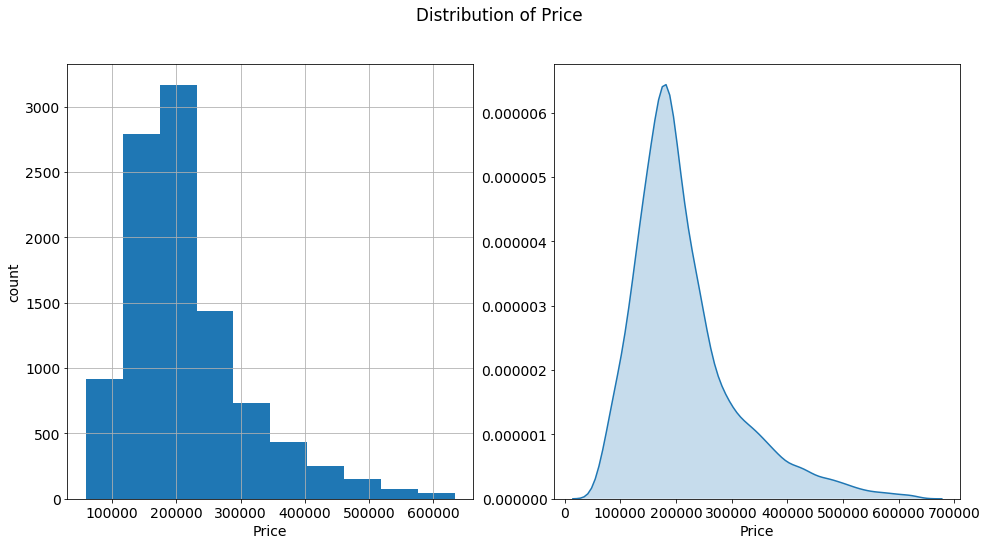

In [65]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [66]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

target_mean, target_median, target_mode

(214138.86, 192269.64487934904, 59174.77802758122)

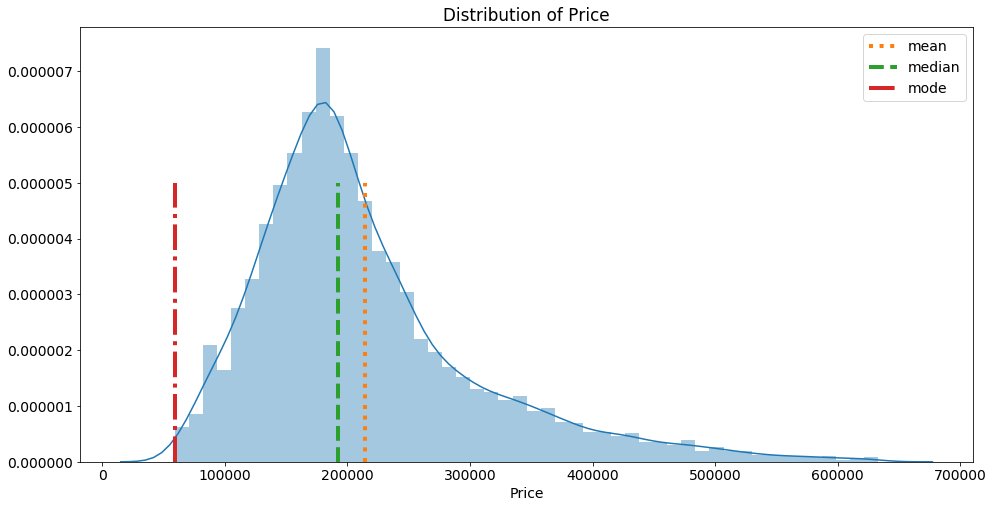

In [67]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean]*100 , y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median]*100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode]*100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

### Оценка распредения целевой переменной в разрезе других признаков

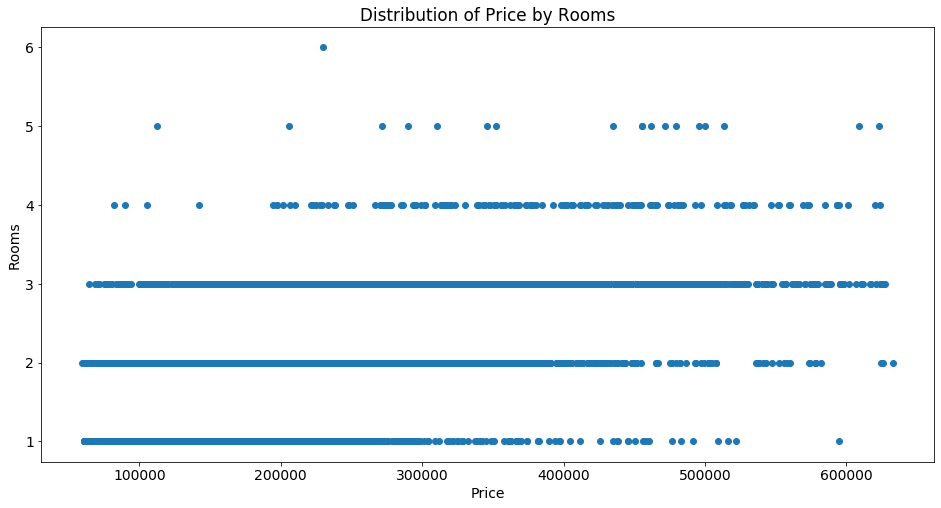

In [68]:
plt.figure(figsize=(16, 8))

plt.scatter(df['Price'], df['Rooms'])

plt.xlabel('Price')
plt.ylabel('Rooms')
plt.title('Distribution of Price by Rooms')
plt.show()

### Анализ признаков

**Количественные признаки**

In [69]:
df_num_features = df.select_dtypes(include='float64')

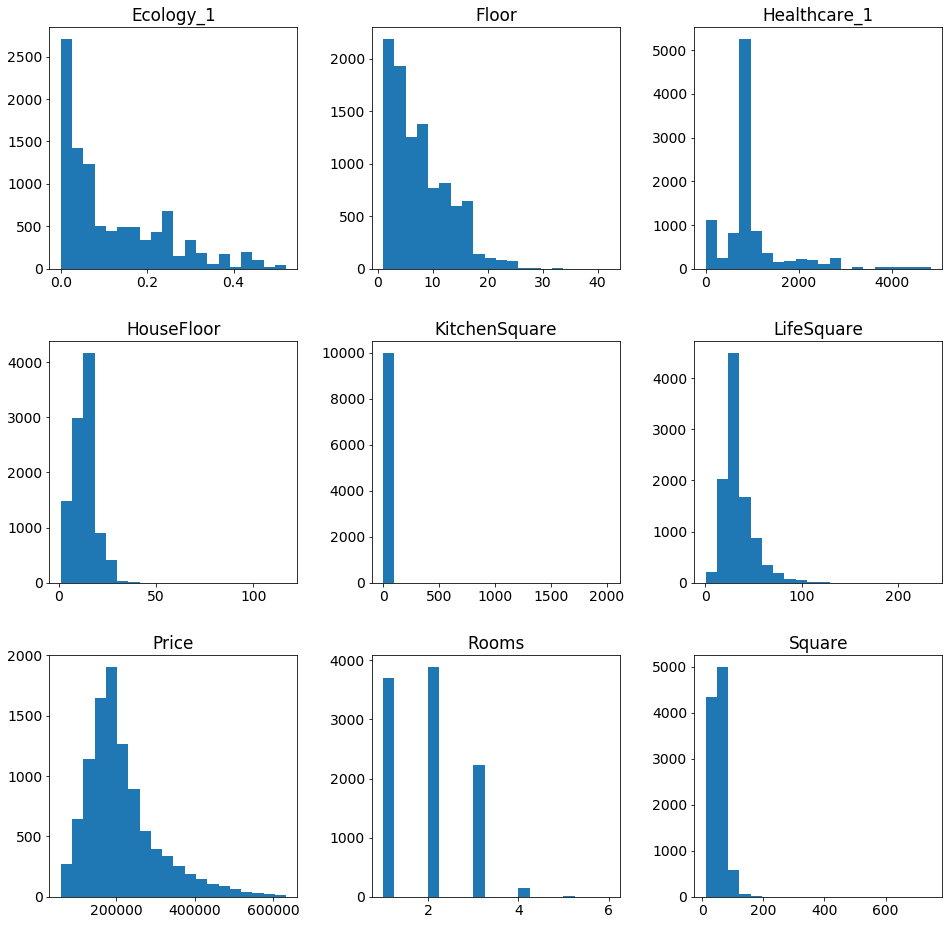

In [70]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

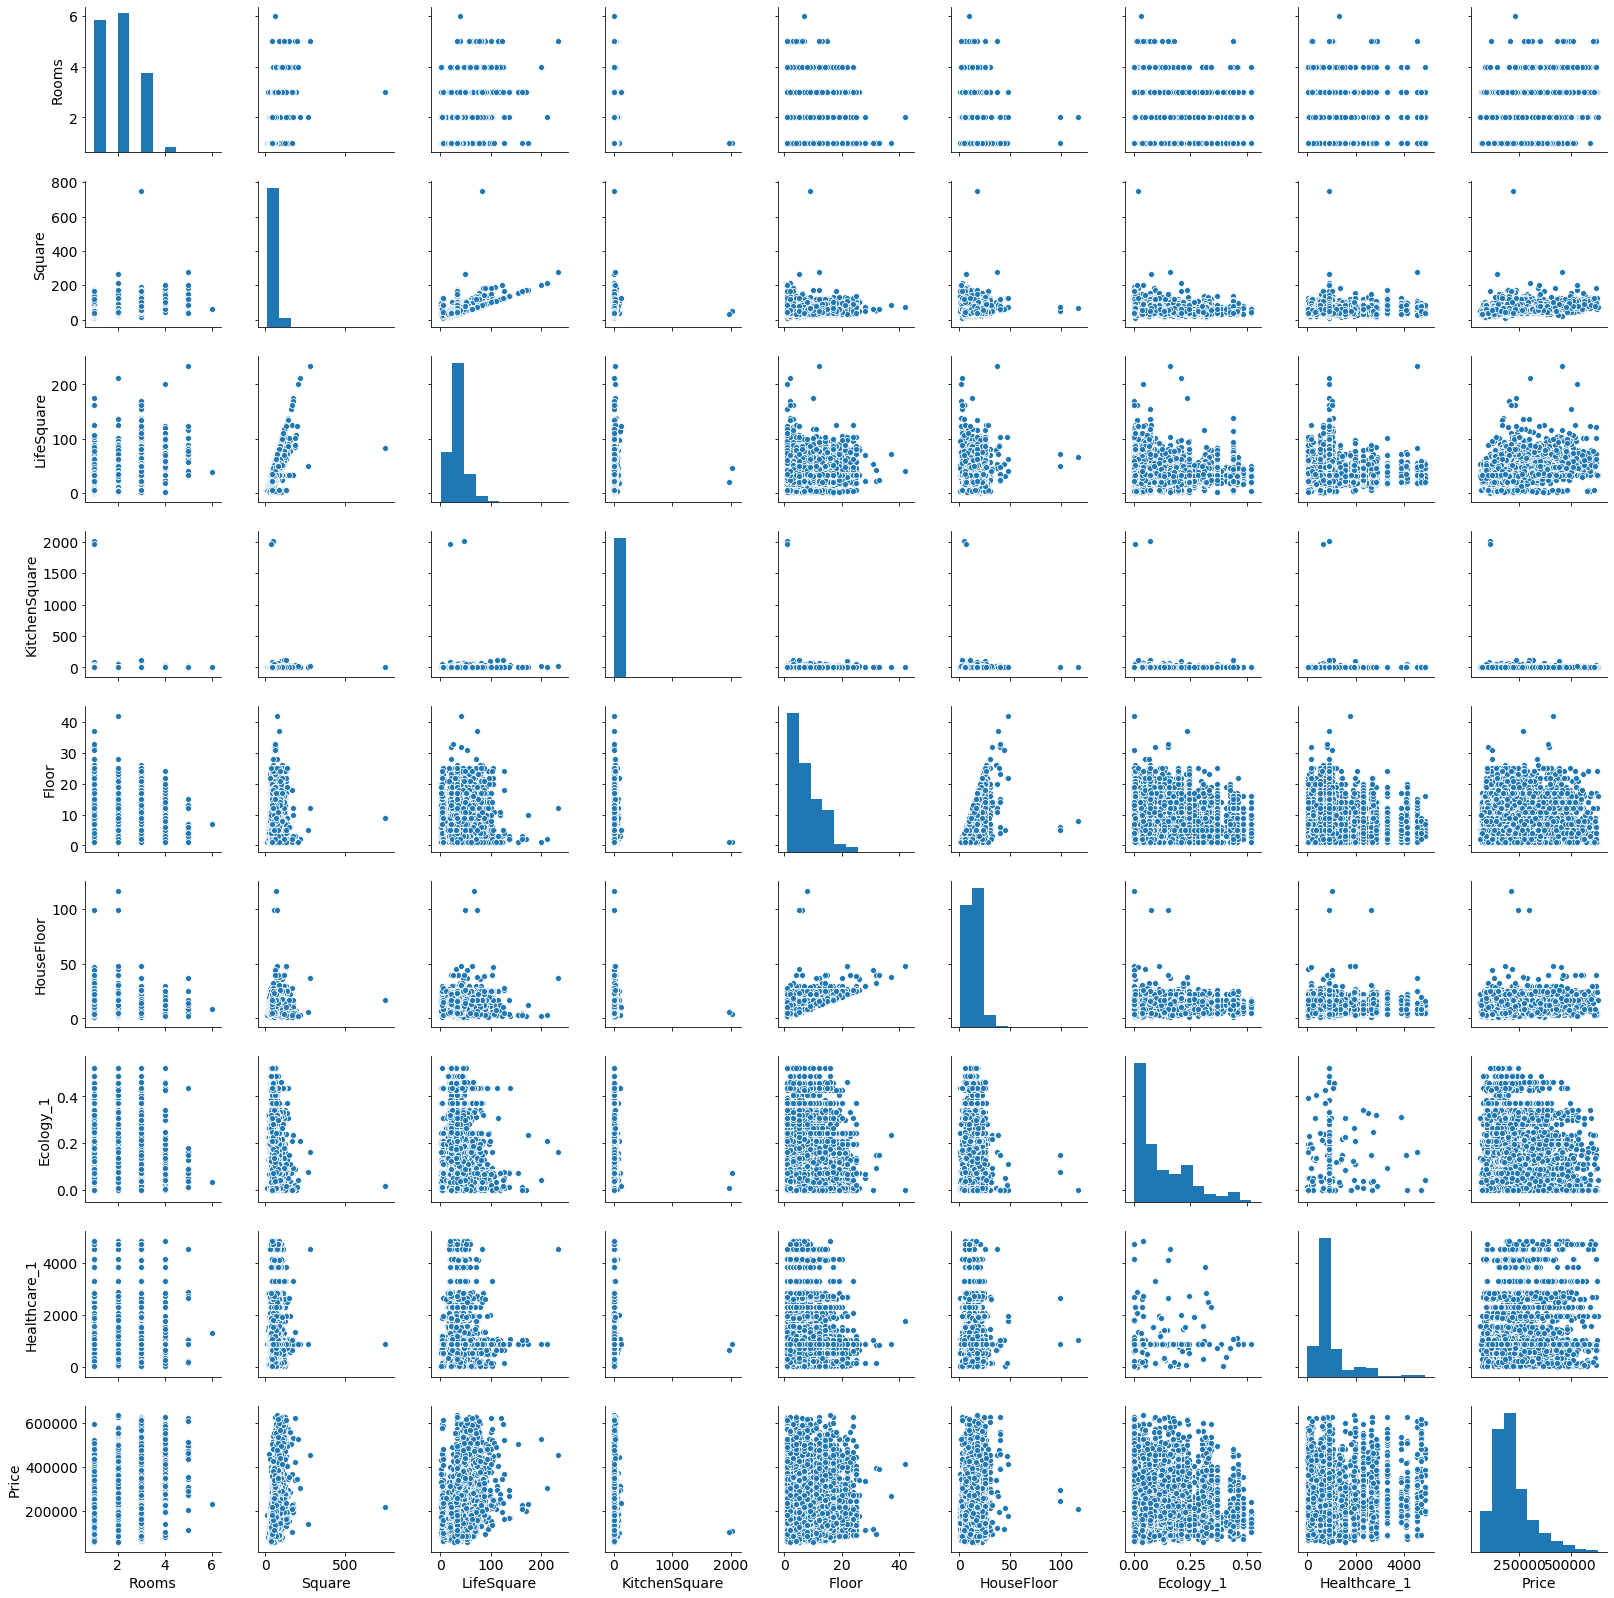

In [71]:
sns.pairplot(df_num_features);

### Матрица корреляций

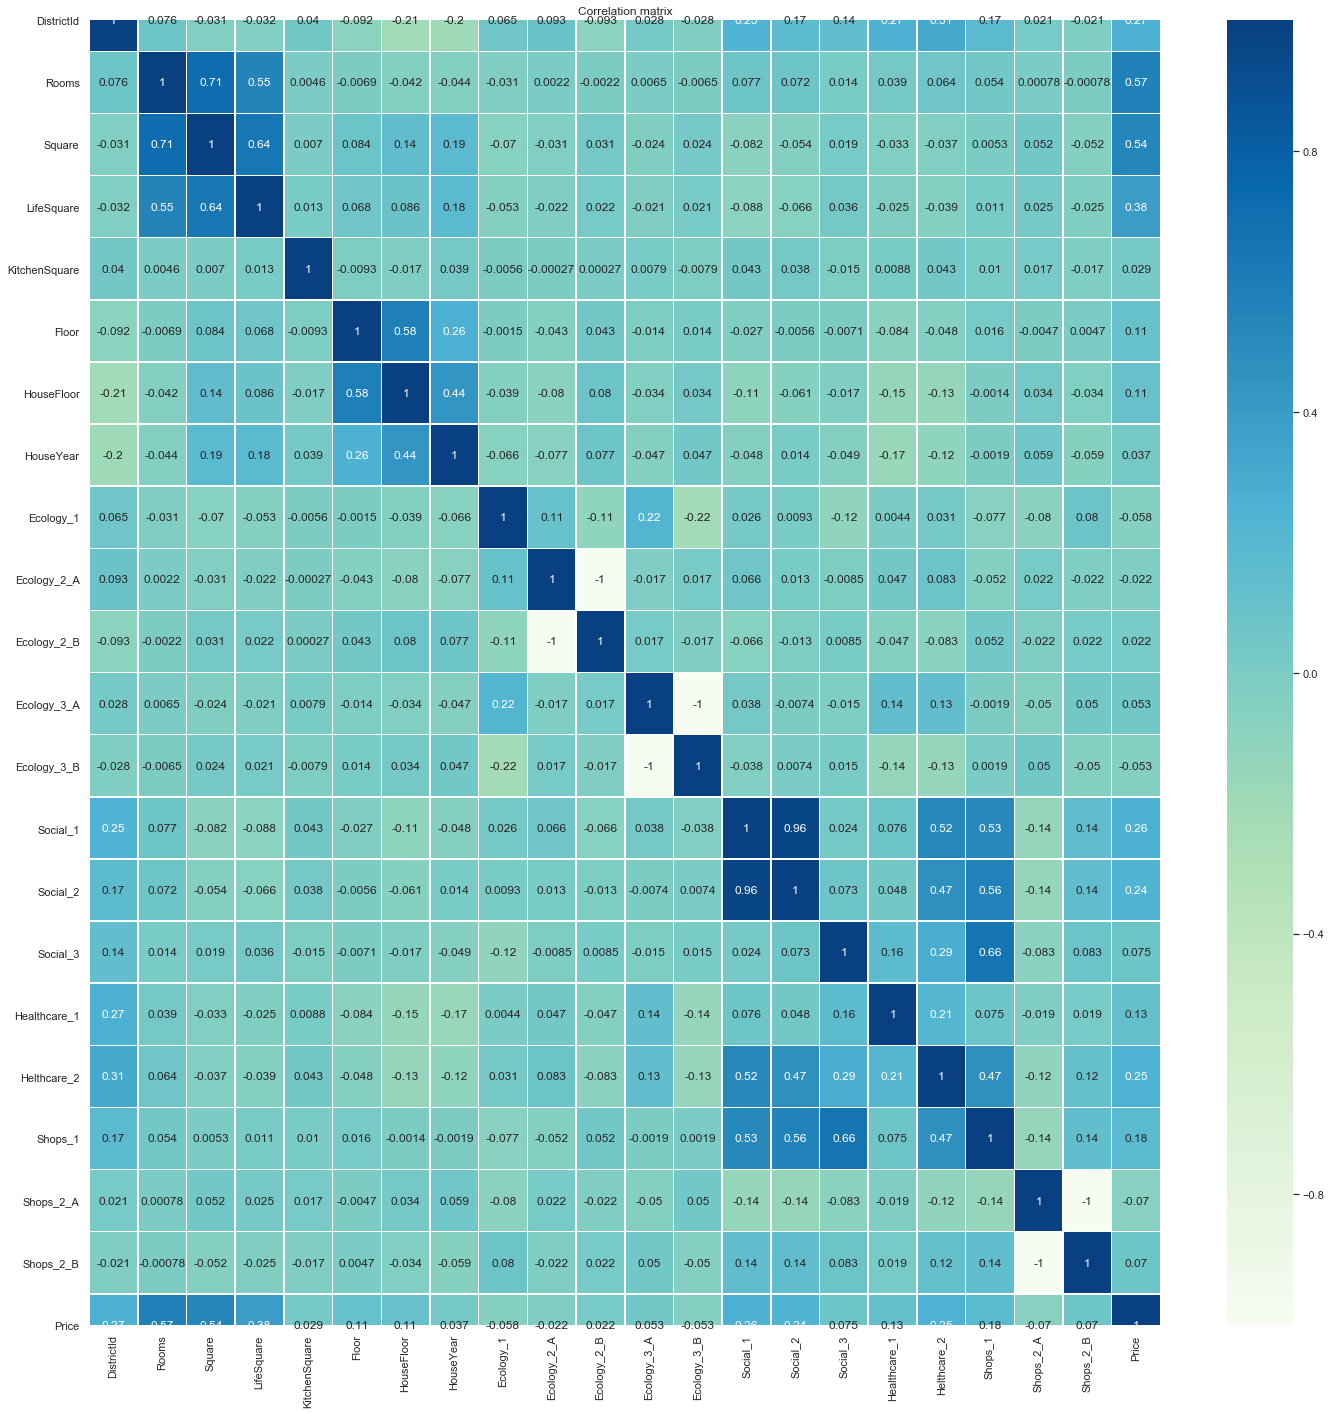

In [72]:
plt.figure(figsize = (24,24))

sns.set(font_scale=1)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [73]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [74]:
PREPARED_DATASET_PATH = 'train_prepared.csv'
TRAIN_DATASET_PATH = 'train_data.csv'
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

In [75]:
df = pd.read_csv(PREPARED_DATASET_PATH)
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_A,...,Ecology_3_B,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_A,Shops_2_B,Price
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,0,...,1,33,7976,5,900.0,0,11,0,1,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,0,...,1,46,10309,1,240.0,1,16,0,1,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8.0,12.0,1968,0.049637,0,...,1,34,7759,0,229.0,1,3,0,1,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,0,...,1,23,5735,3,1084.0,0,5,0,1,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,0,...,1,35,5776,1,2078.0,2,4,0,1,150226.531644


In [76]:
df.shape

(10000, 22)

### Отбор примеров

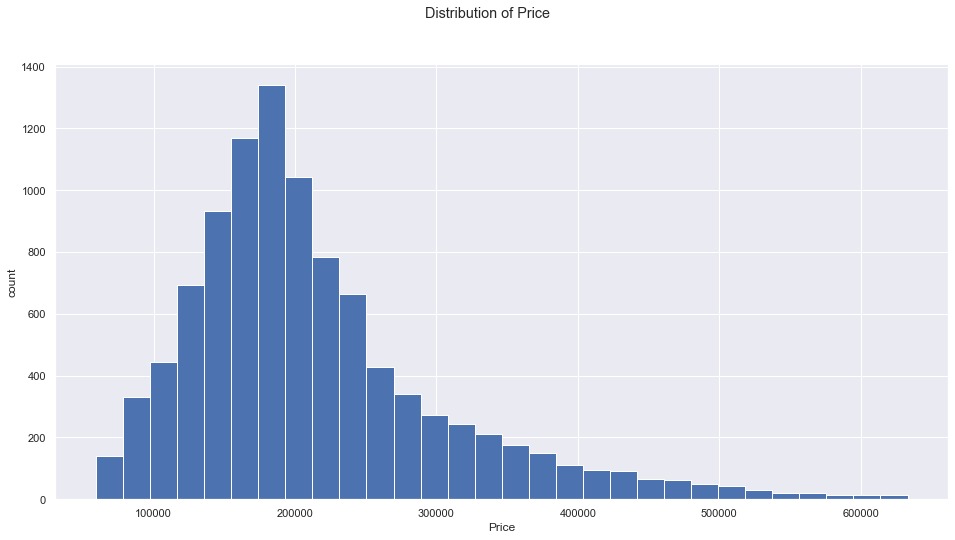

In [77]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

### Отбор признаков

In [78]:
df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2_A',
 'Shops_2_B',
 'Price']

In [79]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
 'Shops_1', 'Shops_2_A', 'Shops_2_B']
target_name = 'Price'

In [80]:
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_A,...,Ecology_3_B,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_A,Shops_2_B,Price
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,0,...,1,33,7976,5,900.0,0,11,0,1,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,0,...,1,46,10309,1,240.0,1,16,0,1,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8.0,12.0,1968,0.049637,0,...,1,34,7759,0,229.0,1,3,0,1,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,0,...,1,23,5735,3,1084.0,0,5,0,1,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,0,...,1,35,5776,1,2078.0,2,4,0,1,150226.531644


### Стандартизация признаков

In [81]:
feature_names_for_stand = df[feature_names].select_dtypes(include='float64').columns.tolist()
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1']

In [82]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [83]:
stand_features

array([[ 0.13693641, -0.41208811, -0.37028541, ..., -0.77425419,
        -0.25052909, -0.16924   ],
       [ 1.36837894,  0.45446438,  0.3044194 , ..., -0.77425419,
        -0.99805257, -1.05321732],
       [ 0.13693641, -0.56058937, -0.38587885, ..., -0.2757217 ,
        -0.58158849, -1.06795027],
       ...,
       [-1.09450612, -0.4141712 , -0.15792068, ...,  0.38898828,
        -0.39237278, -0.16924   ],
       [ 0.13693641, -0.62644899, -0.09056418, ..., -1.43896418,
         1.58469359, -0.93937175],
       [-1.09450612, -0.86807207, -0.89729167, ...,  0.55516578,
        -0.99864062, -1.33448283]])

In [84]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [85]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_A,...,Ecology_3_B,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_A,Shops_2_B,Price
0,35,0.136936,-0.412088,-0.370285,-0.009569,-0.180418,-0.774254,1969,-0.250529,0,...,1,33,7976,5,-0.169240,0,11,0,1,184966.930730
1,41,1.368379,0.454464,0.304419,0.060460,-0.180418,-0.774254,1978,-0.998053,0,...,1,46,10309,1,-1.053217,1,16,0,1,300009.450063
2,53,0.136936,-0.560589,-0.385879,-0.219657,0.010865,-0.275722,1968,-0.581588,0,...,1,34,7759,0,-1.067950,1,3,0,1,220925.908524
3,58,0.136936,-0.149146,1.111128,0.095474,0.010865,0.555166,1977,2.680470,0,...,1,23,5735,3,0.077202,0,5,0,1,175616.227217
4,99,-1.094506,-0.819974,-0.730740,0.025445,0.584713,-0.275722,1976,-0.894969,0,...,1,35,5776,1,1.408526,2,4,0,1,150226.531644


In [86]:
df.to_csv(TRAIN_DATASET_PATH, index=False, encoding='utf-8')

### Разбиение на train и test

In [87]:
X = df[feature_names]
y = df[target_name]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение базовых моделей и выбор лучшей

**Linear Regression**

In [89]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2:	0.512
MAE:	44775.707
MSE:	4185261767.752


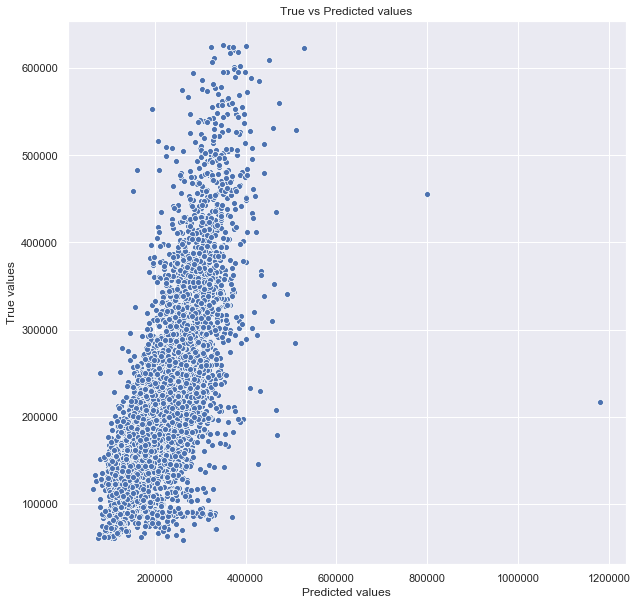

In [90]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.509
MAE:	45230.755
MSE:	4279181219.195


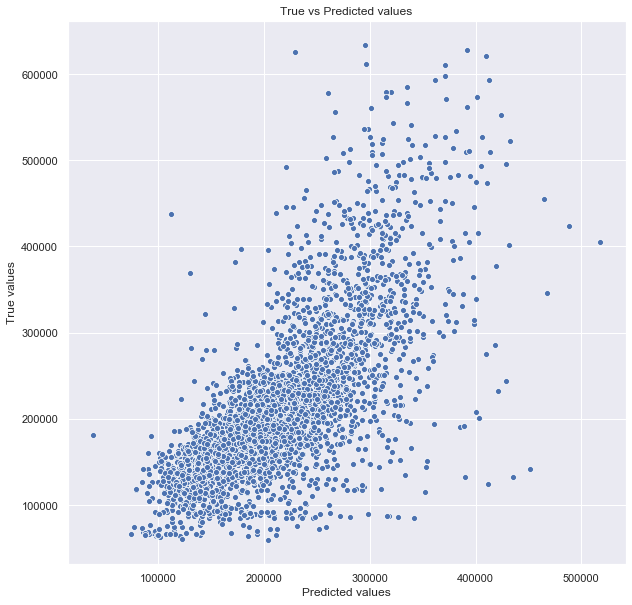

In [91]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**Random Forest**

In [92]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.946
MAE:	12122.912
MSE:	460856054.43


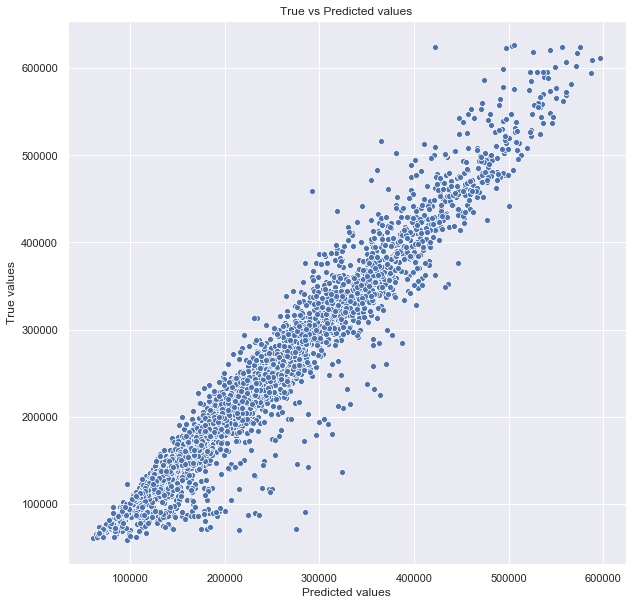

In [93]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.708
MAE:	29963.591
MSE:	2544608785.396


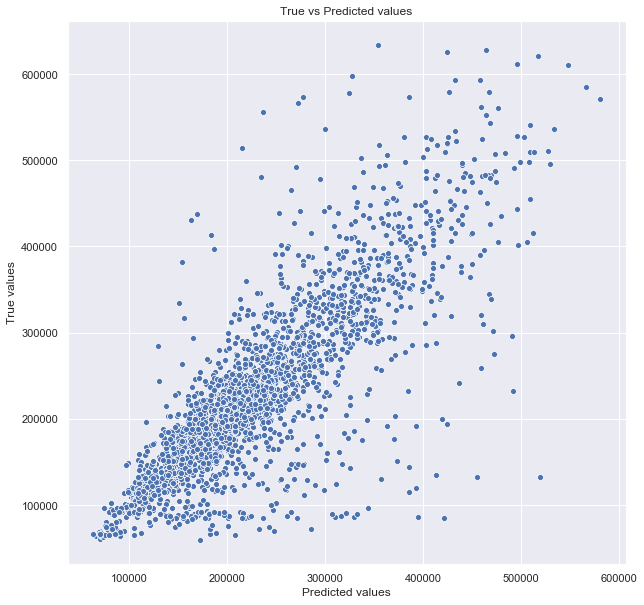

In [94]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**Gradient Boosting**

In [95]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.774
MAE:	28286.793
MSE:	1937964570.384


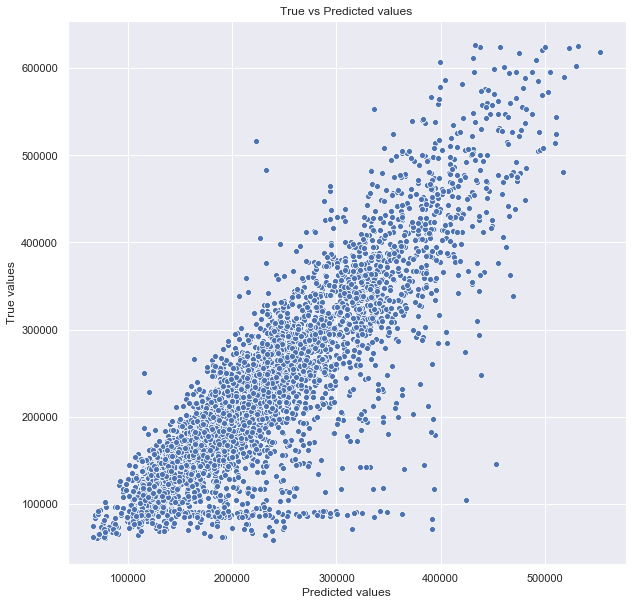

In [96]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.709
MAE:	31192.068
MSE:	2536066380.138


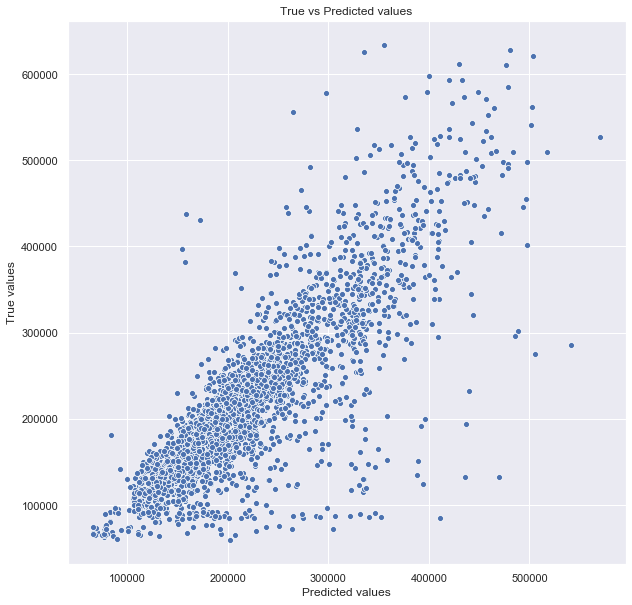

In [97]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Настройка и оценка финальной модели

**Подбор гиперпараметров**

In [98]:
gb_model = GradientBoostingRegressor(random_state=21)
gb_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [99]:
params = {'n_estimators':[50, 100, 150, 200], 
          'max_depth':[3, 4, 5, 6]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                            

In [100]:
gs.best_params_

{'max_depth': 4, 'n_estimators': 200}

In [101]:
gs.best_score_

0.7412327395274256

**Обучение и оценка модели**

In [102]:
final_model = GradientBoostingRegressor(n_estimators=200, max_depth=4, random_state=21)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.863
MAE:	22176.293
MSE:	1177371270.509


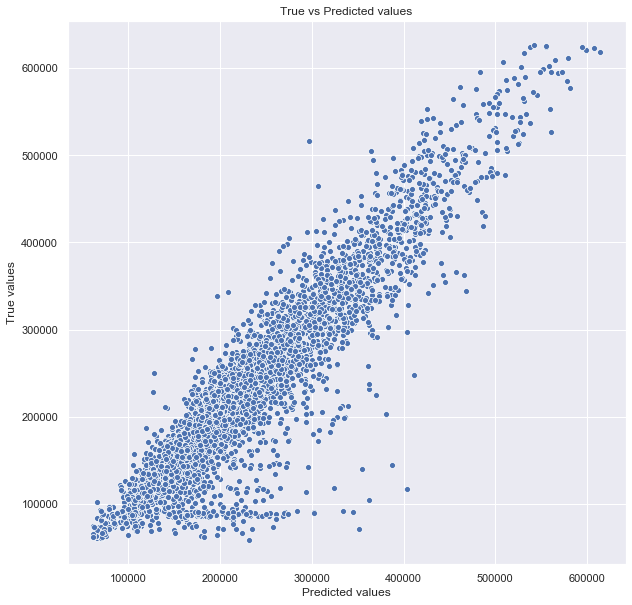

In [103]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.73
MAE:	28646.715
MSE:	2351565674.878


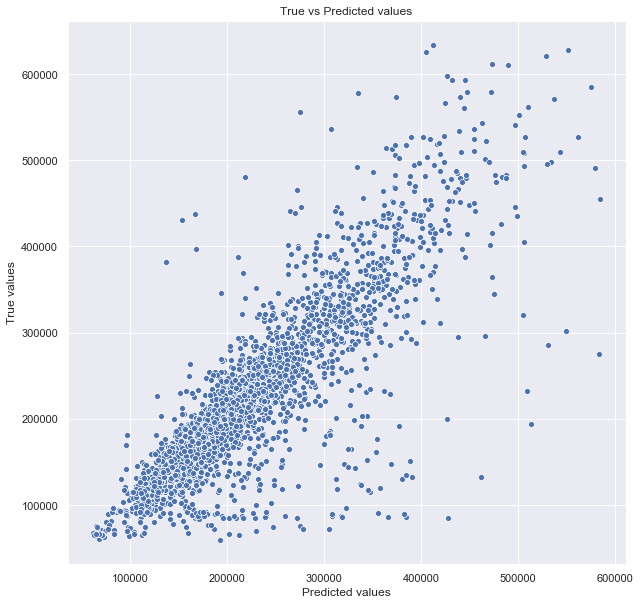

In [104]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**Важность признаков**

In [105]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.441100
13,Social_1,0.114366
15,Social_3,0.072052
0,DistrictId,0.059391
14,Social_2,0.057212
1,Rooms,0.056750
8,Ecology_1,0.045037
6,HouseFloor,0.030513
16,Healthcare_1,0.029552
7,HouseYear,0.029277


### Сохранение модели

**Scaler**

In [106]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

**Model**

In [107]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [108]:
with open(MODEL_FILE_PATH, 'rb') as file:
    model_load=pickle.load(file)

In [109]:
model_load.predict(X_test)==y_test_preds

array([ True,  True,  True, ...,  True,  True,  True])

### Предсказываем цены для тестовых данных и выгружаем в файл

In [110]:
test_data = pd.read_csv('test.csv')

In [111]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [112]:
test_data[test_data['LifeSquare'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5,7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
11,3310,6,3.0,84.625350,NaN,1.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
14,5214,27,1.0,37.555197,NaN,1.0,5,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
21,16688,1,1.0,44.878767,NaN,1.0,1,9.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4723,95,1.0,45.542940,NaN,0.0,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B
4985,11732,1,1.0,46.597283,NaN,1.0,17,24.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4987,5361,53,3.0,80.102103,NaN,1.0,13,22.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [113]:
test_data.loc[test_data['LifeSquare'].isnull(), 'LifeSquare'] = test_data['LifeSquare'].median()

In [114]:
test_data[test_data['Healthcare_1'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,32.925087,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
6,13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,7220,96,3.0,80.182493,48.627326,10.0,10,17.0,2003,0.041116,B,B,53,14892,4,NaN,1,4,B
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B


In [115]:
test_data.loc[test_data['Healthcare_1'].isnull(), 'Healthcare_1'] = test_data['Healthcare_1'].median()

In [116]:
test_data.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [117]:
feature_names_test = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

In [118]:
feature_names_for_stand_test = test_data[feature_names_test].select_dtypes(include='float64').columns.tolist()
feature_names_for_stand_test

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1']

In [119]:
stand_features_test = scaler.fit_transform(test_data[feature_names_for_stand_test])

In [120]:
stand_features_test

array([[ 0.10733317, -0.34397879, -0.1289933 , ...,  0.20608277,
         1.58528022, -0.16881052],
       [ 0.10733317,  0.67119403, -0.16089621, ..., -1.70891084,
        -0.36728275, -0.16881052],
       [-1.08525762, -2.24461561, -1.22769927, ..., -1.11968204,
        -0.99846846,  4.79127789],
       ...,
       [ 1.29992396,  1.12057067,  0.80415198, ...,  1.38454038,
        -0.24217342, -0.16881052],
       [ 0.10733317,  1.30196852, -0.16089621, ..., -1.85621804,
        -0.39744467, -0.16881052],
       [ 0.10733317,  0.21508662, -0.16089621, ...,  0.64800438,
        -0.9978175 ,  0.02166105]])

In [121]:
test_data[feature_names_for_stand_test] = pd.DataFrame(stand_features_test, columns=feature_names_for_stand_test)

In [122]:
X_test = pd.get_dummies(test_data)
X_test.drop("Id", axis=1, inplace=True)
test_data["Price"] = model_load.predict(X_test)

In [123]:
# экспорт в файл
test_data.loc[:, ['Id', 'Price']].to_csv('OGubanikhin_predictions.csv', index=False)